In [1]:
#!pip install pycocotools

In [2]:
#!pip install git+https://github.com/tensorflow/examples.git

In [3]:
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz

In [4]:
#!pip install imantics

In [5]:
from pycocotools.coco import COCO
import numpy as np

import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pydot
from imantics import Polygons, Mask
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import cv2

## For visualizing results

import matplotlib.gridspec as gridspec
import sys
%matplotlib inline

In [6]:
from utils import *
from models.model import *
import rectification as rec

In [7]:
# Parameter
x = 192
y = 192

batch_size = 1
input_image_size = (x,y)
OUTPUT_CHANNELS = 1

folder = 'data/Rathausen_192x192'
mode_train = 'train'

mode_val = 'val'
mode_test = 'test'

folder_deepsolareye = 'data/SolarPanelSoilingImageDataset/Solar_Panel_Soiling_Image_dataset/PanelImages'

EPOCHS = 1
STEPS_PER_EPOCH = 250
#VAL_SUBSPLITS = 5
VALIDATION_STEPS = 4

In [8]:
model = mobile_net_v2([192,192,3])

In [9]:
images_train, dataset_size_train, coco = filterDataset(folder,  mode_train)
#coco_train = copy.deepcopy(coco)
coco_train = coco

images_val, dataset_size_val, coco = filterDataset(folder,  mode_val)
#coco_val = copy.deepcopy(coco)
coco_val = coco

images_test, dataset_size_test, coco = filterDataset(folder,  mode_test)
#coco_val = copy.deepcopy(coco)
coco_test = coco

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [10]:
images_deepsolareye, dataset_size_deepsolareye, coco = filterDatasetDeepSolarEye(folder_deepsolareye)
#coco_val = copy.deepcopy(coco)
coco_deepsolar = coco

In [11]:
gen_train = dataGeneratorCoco(images_train, coco_train, folder,
                            input_image_size, batch_size, mode_train)
#gen1 = dataGeneratorCoco(images, classes, coco, folder,
#                            input_image_size, 1, 'test', mask_type)
gen_val = dataGeneratorCoco(images_val, coco_val, folder,
                            input_image_size, batch_size, mode_val)
gen_test = dataGeneratorCoco(images_test, coco_test, folder,
                            input_image_size, batch_size, mode_test)

In [12]:
type(gen_train)

generator

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=2), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()])

In [14]:
def show_predictions(model, dataset=None, num=4):
    """[summary]

    Args:
        dataset ([type], optional): [description]. Defaults to None.
        num (int, optional): [description]. Defaults to 4.
    """
    if dataset:
        for i in range(0, num):
            image, mask = next(dataset)
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0]])
    else:
        img = model.predict(sample_image)
        display([sample_image[0], sample_mask[0],
             img[0]])

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    """[summary]

    Args:
        tf ([type]): [description]
    """
    def on_epoch_end(self, epoch, logs=True):
        """[summary]

        Args:
            epoch ([type]): [description]
            logs (bool, optional): [description]. Defaults to True.
        """
        clear_output(wait=False)
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))  

In [16]:
img, mask = next(gen_val)
sample_image = img
sample_mask = mask

In [17]:
img = model.predict(sample_image)

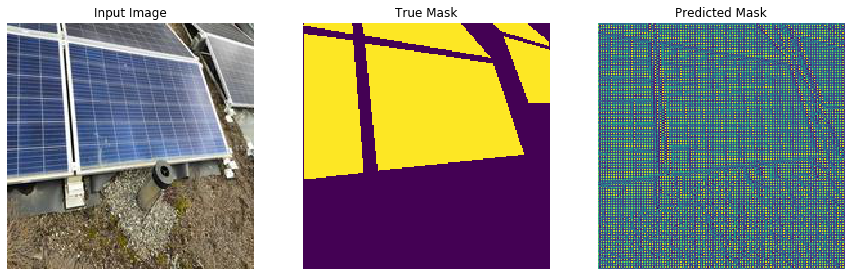

In [18]:
show_predictions(model)

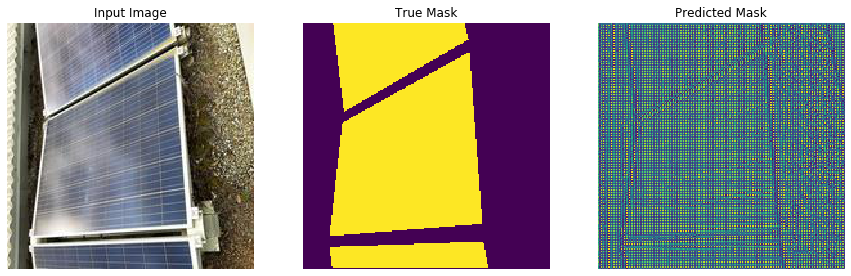

In [19]:
show_predictions(model, gen_train, 1)

In [20]:
training_start_time = time.time()
model_history = model.fit(gen_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=gen_val,
                          callbacks=[DisplayCallback()]
                         )
training_time = time.time() - training_start_time
print("--- %s seconds ---" % (time.time() - training_start_time))

AttributeError: 'builtin_function_or_method' object has no attribute 'time'

In [ ]:
model_history.history.keys()


In [ ]:
loss = model_history.history['val_loss']
accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Cal loss')
plt.plot(epochs, accuracy, 'bo', label='accuracy')
plt.title('Loss and accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
model_history.history['val_accuracy'][-1:]

In [ ]:
#model_history.history['val_accuracy']

In [ ]:
show_predictions(model, gen_train, 1)

In [ ]:
show_predictions(model, gen_val, 3)

In [ ]:
show_predictions(model, gen_test, 3)

In [ ]:
from keras.preprocessing.image import save_img

# Store, Registration and Recification

In [ ]:
import pathlib


In [ ]:
predict_and_store(model, 'test', 'Rathausen_192x192', images_test, dataset_size_test, folder, x, y )

In [ ]:
predict_and_store('test', 'DeepSolarEye_192x192', images_deepsolareye, dataset_size_deepsolareye, folder_deepsolareye, x, y)

## Evaluate

In [ ]:
def calc_predictions(modeldataset=None, num=2):
    dice = []
    jaccard = []
    if dataset:
        for i in range(0, num):
            image, mask = next(dataset)
            pred_mask = model.predict(image)
            dice.append(dice_coef(sample_mask[0], pred_mask[0]))
            jaccard.append(jaccard_distance(sample_mask[0], pred_mask[0]))
            #display([image[0], mask[0], pred_mask[0]])
    print("Dice", np.mean(dice))
    print("Jaccard", np.mean(jaccard))
    
    return dice, jaccard

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [ ]:
val_dice, val_jaccard = calc_predictions(gen_val, 50)

In [ ]:
test_dice, test_jaccard = calc_predictions(gen_test, 33)

In [ ]:
jaccard

In [ ]:
print(np.mean(dice))

In [ ]:
test_loss, test_accuracy = model.evaluate(gen_test, batch_size=batch_size, steps=33)

In [ ]:
# Print Model Summary:
print("MODEL SUMMARY")
print("-------------")
print("Training Accuracy:", model_history.history['accuracy'][-1:][0])
print("Validation Accuracy:", model_history.history['val_accuracy'][-1:][0])
print("Test Accuracy:", test_accuracy)
print("-------------")
print("Training Loss:", model_history.history['loss'][-1:][0])
print("Validation Loss:", model_history.history['val_loss'][-1:][0])
#print("Training mean_io_u:", model_history.history['mean_io_u'][-1:][0])
#print("Validation mean_io_u:", model_history.history['mean_io_u'][-1:][0])
print("-------------")
print("Validation Dice:", np.mean(val_dice))
print("Validation Jaccard:", np.mean(val_jaccard))
print("Test Dice:", np.mean(test_dice))
print("Test Jaccard:", np.mean(test_jaccard))

